# Parameter Ensemble
## Goal: sample parameter uncertainty using an ensemble within probable ranges & develop means to visualize extremes
- Parameters in FaIR are termed "configs" (climate and species configs)

### Erica Simon, 01/23/24
This notebook is adapted from the following example: https://github.com/OMS-NetZero/FAIR/blob/master/docs/examples/calibrated_constrained_ensemble.rst

## Imports

In [125]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import xarray as xr
import numpy as np
import pandas as pd
import pooch
import seaborn as sns

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## Create instance

In [126]:
f = FAIR(ch4_method="Thornhill2021")

## Define time horizon

In [127]:
f.define_time(1850, 2100, 1)

## Define scenarios

We will use the SSPs as our scenarios for simplicity, allowing us to isolate the strategy of parameter uncertainty.

In [128]:
scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp534-over", "ssp585"]
f.define_scenarios(scenarios)

## Define configs

We retrieve the parameter ensemble from Dr. Smith's Zenodo.

This is the currently the most recent dataset (calibration v1.4, Jan 2024), but check this link to see if a new version has been posted: https://zenodo.org/records/10208609

If you want to change the version, you need to change both the URL and the known_hash. To get the hash for the new URL, simply substitute the new URL and run the block of code. It will display an error message, which contains the hash for the new URL.

In [129]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/10566813/files/calibrated_constrained_parameters.csv',
    known_hash = '76e2b9156ed26aa2730aa7023f1e40025a3637fe479df18e822120eff001848c'
)

In [130]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [131]:
df_configs.head()

,clim_gamma,clim_c1,clim_c2,clim_c3,clim_kappa1,clim_kappa2,clim_kappa3,clim_epsilon,clim_sigma_eta,clim_sigma_xi,...,fscale_minorGHG,fscale_Stratospheric water vapour,fscale_Land use,fscale_Volcanic,fscale_solar_amplitude,fscale_solar_trend,fscale_Light absorbing particles on snow and ice,fscale_CO2,cc_co2_concentration_1750,seed
1234,0.622618,4.680552,23.295099,56.346112,1.694550,3.302788,1.007776,1.294582,0.534052,0.440174,...,1.130601,1.418958,1.197356,1.192193,0.595296,-0.120157,2.168809,0.934679,278.359215,1848129
2451,1.726500,3.233524,26.739721,61.132256,1.573492,2.010692,0.522248,1.180095,0.647172,0.283347,...,0.977664,1.773187,0.304993,1.038236,1.020849,0.031542,1.971089,0.853681,280.218300,2333712
5859,10.594030,5.245431,12.865948,97.651534,1.116086,2.398415,0.565062,1.687383,1.216485,0.708414,...,1.079184,0.904936,0.444871,0.926377,1.274173,0.032360,1.188882,1.053831,276.612839,3693504
5883,2.529501,4.594717,10.538644,77.174420,1.784145,2.745979,1.262495,1.436210,0.714796,0.408356,...,0.961674,1.086858,0.592382,0.785747,0.901432,-0.013991,1.435798,0.884792,276.970838,3703080
14573,8.190986,4.154516,18.761754,62.103433,1.372179,2.219757,1.402622,1.273905,1.006219,0.517088,...,0.953067,0.342868,0.824361,0.821340,1.278124,-0.050726,1.339393,1.098433,279.915729,7170390


## Define species and properties

Fill species and properties from csv file. There are 63 species, which all act as forcing agents.

Note that contrails are removed. This agent is not included in FaIR calibration v1.4 "since few IAM scenarios provide detailed enough information to assess their future forcing"

In [132]:
species_configs = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv',
    known_hash = '4f9d25b21d632cf35953842a627db4b1612b465f68b2a824afff017a7390053b',
)

In [133]:
species, properties = read_properties(filename=species_configs)
species.remove("Contrails")
f.define_species(species, properties)

## Create input & output arrays

In [134]:
f.allocate()

## Fill data

### Emissions and forcings

Since we defined our scenarios as SSPs, we can use the built in 'fill_from_rcmip' function to populate the emisisons xarray.

Note: RCMIP = Reduced Complexity Model Intercomparison Project

In [135]:
f.fill_from_rcmip()

Next, we will fill in solar and volcanic forcings

In [136]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [137]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

In [138]:
# retreive data
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj, index_col='timebounds')

In [139]:
# populate data for relevant years into numpy array
solar_forcing = np.zeros(251)
volcanic_forcing = np.zeros(251)

solar_forcing = df_solar["erf"].loc[1850:2100].values
volcanic_forcing = df_volcanic["erf"].loc[1850:2100].values

trend_shape = np.ones(251)
trend_shape[:251] = np.linspace(0, 1, 251)

The parameter ensemble is used to scale the volcanic and solar timeseries

In [140]:
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

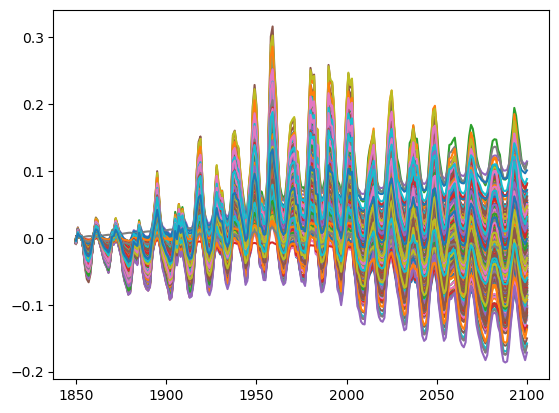

In [141]:
plt.plot(f.timebounds, f.forcing.loc[dict(specie="Solar", scenario="ssp370")]);

#### Adjustments
The content below is taken directly from https://github.com/OMS-NetZero/FAIR/blob/master/docs/examples/calibrated_constrained_ensemble.rst 

This is only required if the 'fill_from_rcmip' function is used to fill the emissions xarray.

There is an issue with the RCMIP NOx emissions; the units are different for biomass burning emissions (Tg NO/yr) to the other emissions from fossil fuels, industry and agriculture (Tg NO2/yr). v1.1 of the calibration uses the corrected NOx emissions expressed in Tg NO2/yr, so we also have to correct them in FaIR for consistency.

We download the RCMIP emissions file, and pull out the relevant sectors, update the unit, and finally override the correct entry of `f.emissions`.

Notes on the below:

- 46.006 is the molecular weight of NO2 (g/mol).
- 30.006 is the molecular weight of NO (g/mol).
- The final `[:550, None]` is to transfer the data coming in from RCMIP (dimension (750,), a timeseries of annual emissions) into the correct shape for our problem (550, 1001). Since we are looping over the `scenario` dimension and selecting it, and we are selecting NOx from the `species` dimension, these axes are collapsed and we're left with (`timepoints`, `configs`). The RCMIP data starts in 1750 as does our emissions data; if there is a mismatch in the start date, it would be necessary to select the correct slice from the RCMIP `DataFrame` that is loaded in. For a reminder of the dimensioning in FaIR 2.1, see https://docs.fairmodel.net/en/latest/intro.html#dimensionality.

In [142]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)

df_emis = pd.read_csv(rcmip_emissions_file)

In [143]:
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]

for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "1850":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "1850":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "1850":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:250, None]

### Climate configs

Simply fill from `calibrated_constrained_parameters.csv`

In [144]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

### Species configs

In [145]:
# get updated defaults
f.fill_species_configs(filename='~/inputs/species_configs_properties_calibration1.2.0.csv')

In [146]:
f.species_configs["baseline_concentration"]

<xarray.DataArray 'baseline_concentration' (config: 841, specie: 63)>
array([[         nan,          nan, 278.3       , ...,          nan,
                 nan, 344.36275911],
       [         nan,          nan, 278.3       , ...,          nan,
                 nan, 344.36275911],
       [         nan,          nan, 278.3       , ...,          nan,
                 nan, 344.36275911],
       ...,
       [         nan,          nan, 278.3       , ...,          nan,
                 nan, 344.36275911],
       [         nan,          nan, 278.3       , ...,          nan,
                 nan, 344.36275911],
       [         nan,          nan, 278.3       , ...,          nan,
                 nan, 344.36275911]])
Coordinates:
  * config   (config) int64 1234 2451 5859 5883 ... 1592589 1594247 1597937
  * specie   (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospheric ...

In [147]:
df_configs["cc_co2_concentration_1750"]

1234       278.359215
2451       280.218300
5859       276.612839
5883       276.970838
14573      279.915729
              ...    
1590667    277.427138
1590821    278.463348
1592589    279.793759
1594247    278.272680
1597937    277.382096
Name: cc_co2_concentration_1750, Length: 841, dtype: float64

We overwrite the `species_configs` that we want to vary as part of the probabilistic sampling

In [148]:
# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC", 
    "CH4", 
    "N2O",
    "NH3", 
    "NOx",
    "OC", 
    "Sulfur", 
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2", 
    "CH4", 
    "N2O", 
    "Stratospheric water vapour",
    # "Contrails",   
    # contrails excluded from this version of calibration data "since few IAM scenarios provide detailed enough information to assess their future forcing"
    "Light absorbing particles on snow and ice", 
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"], 
    df_configs["cc_co2_concentration_1750"].values.squeeze(), 
    specie="CO2"
)

Note that the initial value for CO2 concentration, `cc_co2_concentration_1750`, assumes a start year of 1750. Our simulation starts in 1850, so for now I will assume a small difference in [CO2] in those 100 years due to low emissions. However, I will come back to this to see about changing the start year...

**TODO:** Figure out how to change start year

### Initial conditions

In [149]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)   # this refers to temperature ANOMALY
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## Run

In [150]:
f.run()

Running 6728 projections in parallel:   0%|          | 0/250 [00:00<?, ?timesteps/s]

## Analyze output

In [151]:
fancy_titles = {
    "ssp119": "SSP1-1.9",
    "ssp126": "SSP1-2.6",
    "ssp245": "SSP2-4.5",
    "ssp370": "SSP3-7.0",
    "ssp434": "SSP4-3.4",
    "ssp460": "SSP4-6.0",
    "ssp534-over": "SSP5-3.4-overshoot",
    "ssp585": "SSP5-8.5",
}

# some nice colors provided
ar6_colors = {
    "ssp119": "#00a9cf",
    "ssp126": "#003466",
    "ssp245": "#f69320",
    "ssp370": "#df0000",
    "ssp434": "#2274ae",
    "ssp460": "#b0724e",
    "ssp534-over": "#92397a",
    "ssp585": "#980002",
}

### Temperature anomaly (FaIR Docs)
*This section is taken directly from https://github.com/OMS-NetZero/FAIR/blob/master/docs/examples/calibrated_constrained_ensemble.rst, with Python comments added to aid understanding of the code.*

We define an anomaly baseline of 1850-1900. This is 51 complete years. As FaIR temperature anomalies are on `timebounds`, we take mid-year temperatures as averages of the bounding `timebounds`; so, 1850.5 is an average of 1850.0 and 1851.0. It means we take an average period of 1850-1901 timebounds with 0.5 weights for 1850 and 1901 and 1.0 weights for other `timebounds`.

In [152]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

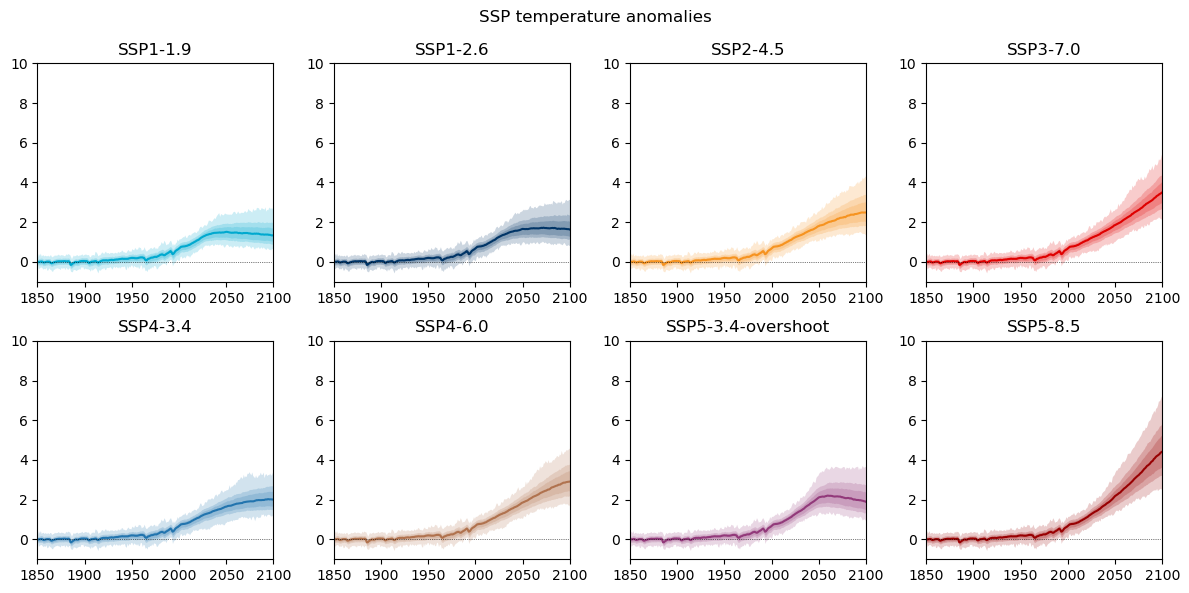

In [153]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        # fills first the range 0-100%, then 5-95%, then 16-84%
        # each time fill is called, the inner range gets darker, leading to more shading for higher probabilities
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                # input array = the temperature anomaly for all 1001 configs
                # percentile (pp[n])- percentage for the percentile to compute
                # axis = 1
                # result: np.percentile computes the nth percentile temperature projection for each year
                f.temperature.loc[dict(scenario=scenario, layer=0)]   
                - np.average(  # the mean temperature anomaly for the period 1850-1900 in each config
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    # plots the median temperature projection as a solid line
    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                weights=weights_51yr,
                axis=0
            ),
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
#     ax[i // 4, i % 4].plot(np.arange(1850.5, 2021), gmst, color="k")
    ax[i // 4, i % 4].set_xlim(1850, 2100)
    ax[i // 4, i % 4].set_ylim(-1, 10)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

plt.suptitle("SSP temperature anomalies")
fig.tight_layout()

#### Test
removing the section that establishes 1850-1900 as the baseline temperature anomaly-- not sure if this is necessary?

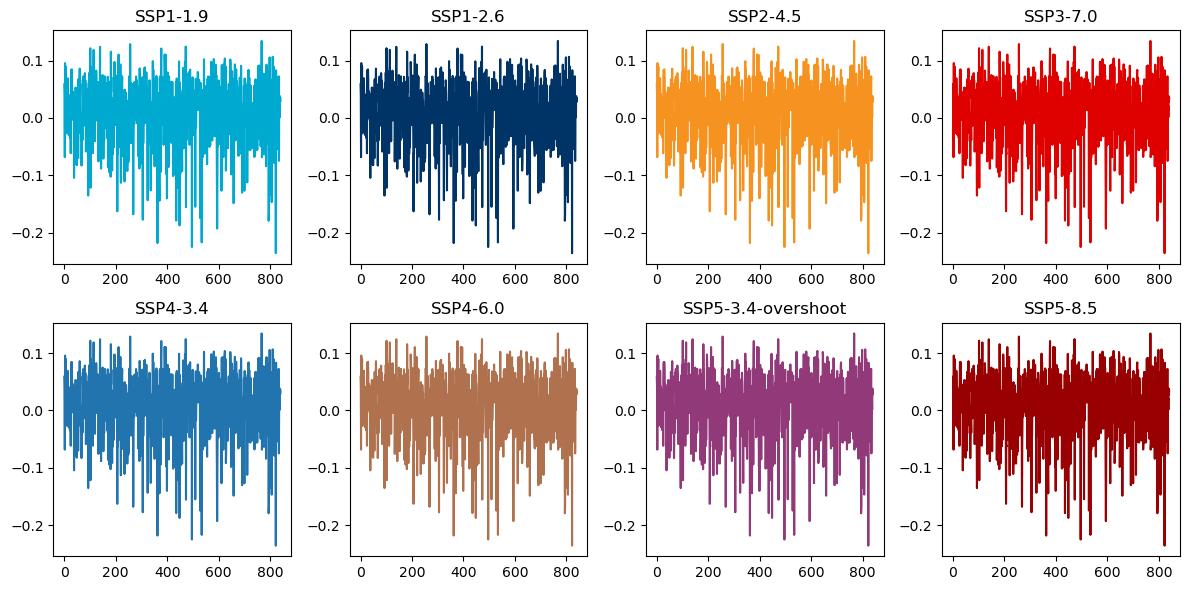

In [154]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    r, c = divmod(i, 4)
    # the mean temperature anomaly for the period 1850-1900
    # weighting applied to adjust for timebounds
    ax[r, c].plot(np.average(f.temperature.loc[dict(timebounds=np.arange(1850, 1902), scenario=scenario, layer=0)], weights=weights_51yr, axis=0),
               color=ar6_colors[scenarios[i]])
    ax[r, c].set_title(fancy_titles[scenarios[i]])

fig.tight_layout()

#### Result
While the baseline temperature anomaly does not appear to differ by scenario, it *does* differ by config.

Crucially, each climate configuration has different assumptions about the initial CO2 concentration (right now formulated as of 1750, even though the analysis begins in 1850... however that is something I am going to work on separately). I'm still not sure if this means that the intitial concentration is important enough to be included, as this would remove the assumption- and isn't the whole point to sample uncertainty in this assumptions? I'll keep it as is for now, but just something to keep in mind for later on...

### Temperature Anomaly (continued)
*This section created by Erica Simon*

Now let's see what other ways we can visualize the temperature anomaly...

Ideas:
- pdf with projections for EOC
- pie chart with probability of overshooting values by EOC (e.g. 1.5, 2, 3)

#### Pre-processing

Let's start by focusing on temperature projections for 2100

In [155]:
eoc = f.temperature.loc[dict(timebounds=2100, layer=0)]
eoc

<xarray.DataArray (scenario: 8, config: 841)>
array([[1.01882139, 1.3011207 , 1.54645605, ..., 0.98058939, 1.31677407,
        1.64017907],
       [1.24132051, 1.58491819, 1.88338756, ..., 1.22785402, 1.5640901 ,
        2.02850716],
       [1.89721467, 2.39043722, 2.97167204, ..., 1.9396778 , 2.36278051,
        3.05234735],
       ...,
       [2.27439998, 2.9331041 , 3.35117186, ..., 2.29549851, 2.72112492,
        3.42807736],
       [1.42427911, 1.8700197 , 2.26834664, ..., 1.42320685, 1.74513732,
        2.39829475],
       [3.17782748, 4.19816771, 5.3749652 , ..., 3.51896272, 3.97869785,
        5.33963152]])
Coordinates:
    timebounds  float64 2.1e+03
  * scenario    (scenario) <U11 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'
  * config      (config) int64 1234 2451 5859 5883 ... 1592589 1594247 1597937
    layer       int64 0

Next, let's get this xarray in terms of temperature anomalies relative to the baseline (1850-1900).

*I'm not sure how relevant this step is, but I'm going to perform it for now, and it can always be taken out later*

In [156]:
baseline_temp = np.average(f.temperature.loc[dict(timebounds=np.arange(1850, 1902), layer=0)], weights=weights_51yr, axis=0)
baseline_temp.shape

(8, 841)

In [157]:
eoc_temp = eoc - baseline_temp
eoc_temp

<xarray.DataArray (scenario: 8, config: 841)>
array([[0.96013284, 1.26049737, 1.61481235, ..., 0.94246757, 1.288873  ,
        1.60552892],
       [1.18263196, 1.54429486, 1.95174387, ..., 1.1897322 , 1.53618903,
        1.99385701],
       [1.83852612, 2.34981389, 3.04002835, ..., 1.90155598, 2.33487944,
        3.0176972 ],
       ...,
       [2.21571143, 2.89248078, 3.41952817, ..., 2.25737669, 2.69322385,
        3.39342721],
       [1.36559057, 1.82939638, 2.33670295, ..., 1.38508503, 1.71723625,
        2.36364459],
       [3.11913894, 4.15754438, 5.4433215 , ..., 3.4808409 , 3.95079678,
        5.30498137]])
Coordinates:
    timebounds  float64 2.1e+03
  * scenario    (scenario) <U11 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'
  * config      (config) int64 1234 2451 5859 5883 ... 1592589 1594247 1597937
    layer       int64 0

Let's isolate to one scenario for now

In [158]:
eoc_temp_119 = eoc_temp.loc[dict(scenario='ssp119')]
eoc_temp_119

<xarray.DataArray (config: 841)>
array([0.96013284, 1.26049737, 1.61481235, 0.8756619 , 1.36939222,
       1.22002594, 1.31010941, 1.17559084, 1.20559537, 1.40335198,
       1.1691098 , 1.01771213, 1.44441354, 1.54138889, 1.10670463,
       1.76190072, 1.02393135, 1.23534244, 1.21794182, 1.98406875,
       0.92513191, 1.06413335, 1.09308333, 1.42709982, 1.26701967,
       1.09051979, 1.18040022, 1.28520207, 1.39240496, 1.31109459,
       0.97122098, 1.04108777, 0.90045895, 1.07657167, 1.7188633 ,
       1.15480132, 1.48322267, 0.89586654, 1.92570258, 1.02617713,
       1.18492892, 1.22430067, 1.66128523, 1.90601215, 0.74600436,
       1.04211576, 0.9353546 , 1.52125705, 1.73027927, 1.23394809,
       1.38018348, 1.13633027, 1.3686714 , 1.16843374, 1.41898662,
       1.44702953, 1.3261714 , 0.89533186, 1.37343004, 1.43217887,
       1.86055215, 1.14309536, 1.40483764, 1.1664687 , 1.0961757 ,
       1.59378028, 1.54427735, 1.56675726, 1.31796555, 1.15311209,
       1.37933895, 1.42492457, 1.03366231, 1.92024688, 1.42945715,
       1.36155799, 1.88280978, 1.27064941, 1.36402711, 1.41606471,
       0.96354111, 1.48240726, 1.1320554 , 1.57062139, 1.95147717,
       1.62880188, 1.7480257 , 1.53353495, 1.56791867, 1.50157664,
       2.08788306, 0.71773444, 1.78354394, 2.20298829, 1.21925075,
       0.90940512, 1.21739344, 1.65861917, 1.3807424 , 1.48157048,
...
       1.25115996, 1.18896391, 1.38676474, 1.23507258, 1.34990652,
       1.66965822, 1.60801323, 1.27430128, 0.89505141, 1.4398738 ,
       2.0183469 , 1.53596649, 0.89998572, 2.47533018, 1.12417637,
       1.27832545, 1.77246601, 0.98932954, 1.91079778, 0.97698078,
       1.39401081, 1.58376905, 1.19822791, 1.28451065, 1.34939068,
       2.02064275, 1.18015124, 1.33135746, 1.40798416, 1.39717702,
       0.92978997, 1.51336491, 1.13813155, 1.07382921, 1.39617025,
       2.1785407 , 1.60940496, 1.93043786, 1.05221707, 1.61332178,
       1.23982121, 1.67089133, 1.51351352, 1.40402675, 1.67466977,
       0.86012496, 1.03616192, 0.9379351 , 1.57211977, 2.15262988,
       1.90633206, 1.80379131, 1.64790233, 0.9942858 , 1.74392972,
       1.58746183, 1.14360558, 1.95035028, 1.28815901, 1.29513241,
       1.57054856, 1.97798124, 1.42988326, 1.43951517, 1.20910494,
       1.34327619, 1.52091582, 1.74809885, 1.15359182, 0.96062244,
       1.07353112, 1.71576155, 0.89311802, 1.26481263, 1.27310895,
       0.9827701 , 1.09228935, 2.36783567, 1.83531837, 1.14700431,
       1.59019612, 1.23864525, 1.52397105, 1.22935769, 1.25943485,
       1.59762835, 1.64321273, 1.1759875 , 1.55594816, 1.76089098,
       2.00636466, 1.38939366, 1.23912673, 0.94246757, 1.288873  ,
       1.60552892])
Coordinates:
    timebounds  float64 2.1e+03
    scenario    <U11 'ssp119'
  * config      (config) int64 1234 2451 5859 5883 ... 1592589 1594247 1597937
    layer       int64 0

Now we have ssp-119 at year 2100 with 841 climate configurations, giving us 841 temperature projections. We want to visualize them probabilistically. A density function would be a good place to start.

**KDE vs. PDF??**
- KDE does not assume a specific parametric distribution, while PDF does (default is normal distribution). Given that we don't know the shape of the distribution (other than that it is probably fat-tailed), I think a KDE is better for now.

#### KDE

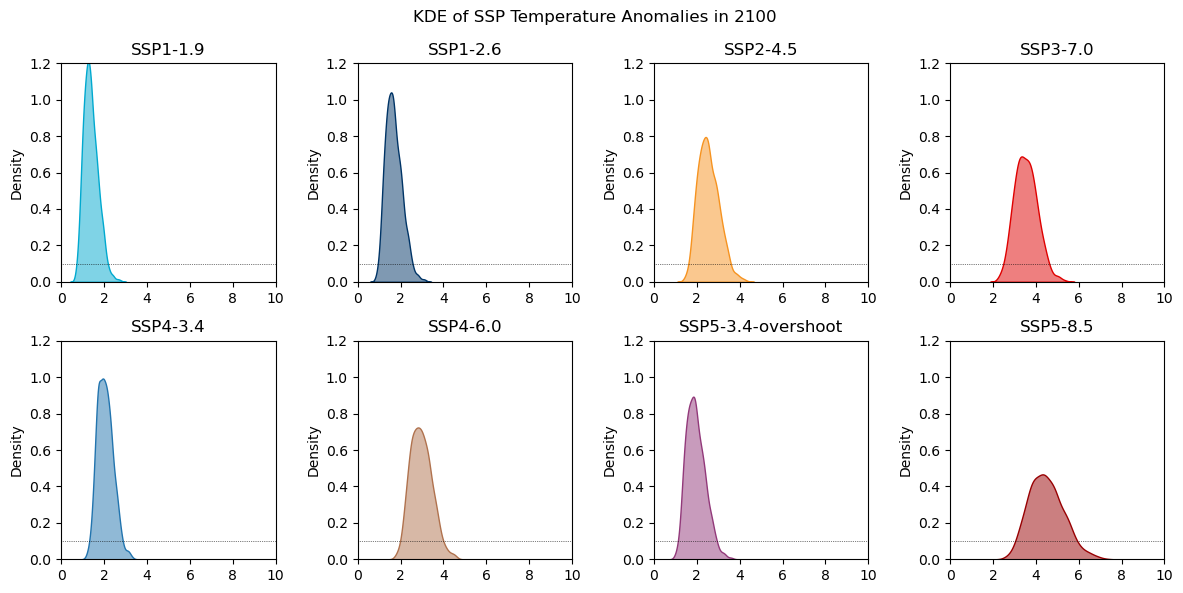

In [159]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    r, c = divmod(i, 4)
    
    sns.kdeplot(eoc_temp.loc[dict(scenario=scenario)], color=ar6_colors[scenarios[i]], ax=ax[r,c], fill=True, alpha=0.5)
    ax[r,c].set_title(fancy_titles[scenarios[i]])
    ax[r,c].axhline(0.1, color="k", ls=":", lw=0.5)
    ax[r,c].set_xlim(0, 10)
    ax[r,c].set_ylim(0, 1.2)

plt.suptitle("KDE of SSP Temperature Anomalies in 2100")
fig.tight_layout()

#### PDF

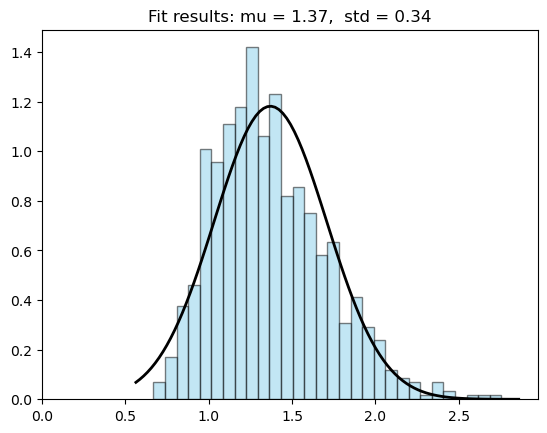

In [160]:
from scipy.stats import norm


data = eoc_temp_119

# Plot the histogram
plt.hist(data, bins=30, density=True, alpha=0.5, color='skyblue', edgecolor='black')

# Fit a PDF (normal distribution in this case)
mu, std = norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.xlim(0)

# Show the plot
plt.title('Fit results: mu = %.2f,  std = %.2f' % (mu, std))
plt.show()


(0.0, 2.9733150485417976)

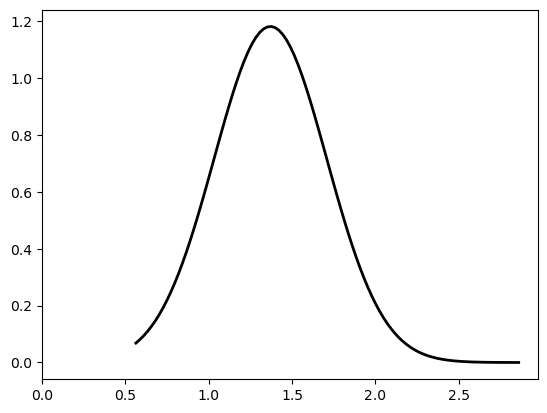

In [161]:
plt.plot(x, p, 'k', linewidth=2)
plt.xlim(0)

#### Pie Chart

Next, let's try visualizing the percent of configs that have warming outcomes in specific temp ranges by EOC. First, let's create a DataArray that has the percent of configs with an outcome in each warming range

In [162]:
ranges = [(0, 1.5), (1.5, 3), (3, 4.5), (4.5, 100)]

# Create a new DataArray to store the percents
perc_array = xr.DataArray(np.zeros((len(ranges), len(eoc_temp.scenario))), dims=('range', 'scenario'))

# Count values in each range for each scenario
for i, (low, high) in enumerate(ranges):
    perc_array[i, :] = ((eoc_temp >= low) & (eoc_temp <= high)).sum(dim='config') / 1001

# Assign names to coordinates
perc_array = perc_array.assign_coords(scenario=eoc_temp.scenario.values)
perc_array = perc_array.assign_coords(range=[f'{low} - {high} C' for (low, high) in ranges])
# perc_array = perc_array.rename({'4.5 - 100 K': '4.5+ K'}, inplace=True)

rounded_perc_array = perc_array.round(decimals=2)

In [163]:
# Update the label for range 4.5 - 100 K --> 4.5+ K
new_coords = {coord: ['4.5+ C' if val == '4.5 - 100 C' 
                      else val for val in rounded_perc_array.coords[coord].values] for coord in rounded_perc_array.coords}
rounded_perc_array = xr.DataArray(rounded_perc_array.values, dims=rounded_perc_array.dims, coords=new_coords)

rounded_perc_array

<xarray.DataArray (range: 4, scenario: 8)>
array([[0.58, 0.3 , 0.  , 0.  , 0.04, 0.  , 0.13, 0.  ],
       [0.26, 0.54, 0.69, 0.14, 0.79, 0.47, 0.7 , 0.01],
       [0.  , 0.  , 0.15, 0.67, 0.01, 0.37, 0.01, 0.44],
       [0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.39]])
Coordinates:
  * scenario  (scenario) <U11 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'
  * range     (range) <U9 '0 - 1.5 C' '1.5 - 3 C' '3 - 4.5 C' '4.5+ C'

Visualize `rounded_perc_array` as pie charts

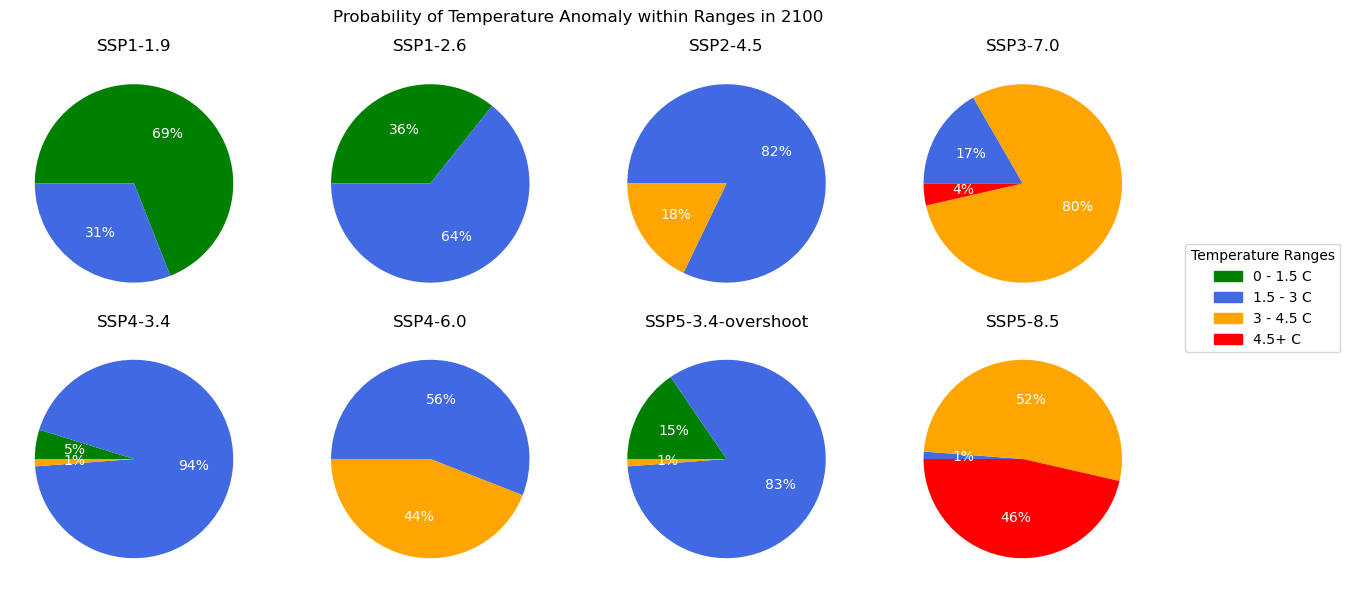

In [164]:
pie_colors = {
    "0 - 1.5 C": "green",
    "1.5 - 3 C": "royalblue",
    "3 - 4.5 C": "orange",
    "4.5+ C": "red",
}

patches = [mpatches.Patch(color=pie_colors[key], label=key) for key in pie_colors]

labels = rounded_perc_array.range.values

fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    curr_array = rounded_perc_array.sel(scenario=scenario)
    
    # we want to get rid of any ranges with 0% occurence, as they aren't relevant for a pie chart
    non_zero_percs = [value for value in curr_array.values if value != 0]
    non_zero_labels = [f'{label}' for label in labels if curr_array.sel(range=label) != 0]
    colors = [pie_colors[label] for label in labels if curr_array.sel(range=label) != 0]
    
    r, c = divmod(i, 4)
    
    ax[r, c].pie(non_zero_percs, autopct='%1.f%%', colors=colors, startangle=180, counterclock=False, textprops=dict(color="w"))
    ax[r, c].set_title(fancy_titles[scenarios[i]])    

fig.legend(handles=patches,
          title="Temperature Ranges",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

fig.suptitle('Probability of Temperature Anomaly within Ranges in 2100')
fig.tight_layout()

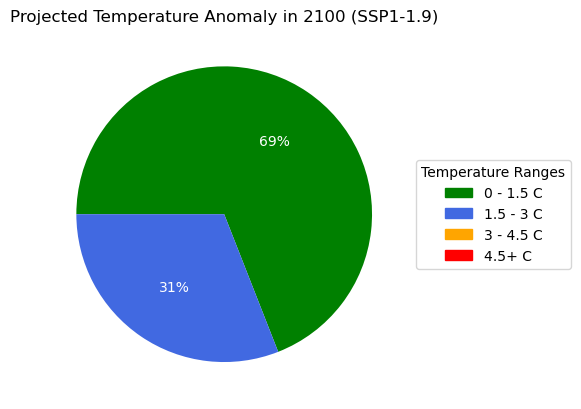

In [165]:
curr_array = rounded_perc_array.sel(scenario='ssp119')
# we want to get rid of any ranges with 0% occurence, as this aren't relevant for a pie chart
non_zero_percs = [value for value in curr_array.values if value != 0]
non_zero_labels = [f'{label}' for label in labels if curr_array.sel(range=label) != 0]
colors = [pie_colors[label] for label in labels if curr_array.sel(range=label) != 0]

plt.pie(non_zero_percs, autopct='%1.f%%', colors=colors, startangle=180, counterclock=False, textprops=dict(color="w"))
plt.legend(handles=patches,
          title="Temperature Ranges",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Projected Temperature Anomaly in 2100 (SSP1-1.9)')
plt.show()

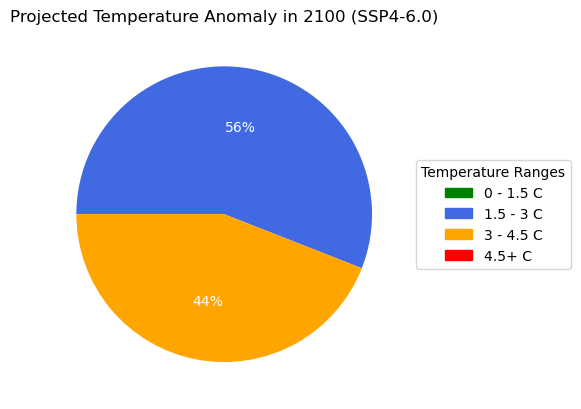

In [166]:
curr_array = rounded_perc_array.sel(scenario='ssp460')
# we want to get rid of any ranges with 0% occurence, as this aren't relevant for a pie chart
non_zero_percs = [value for value in curr_array.values if value != 0]
non_zero_labels = [f'{label}' for label in labels if curr_array.sel(range=label) != 0]
colors = [pie_colors[label] for label in labels if curr_array.sel(range=label) != 0]

plt.pie(non_zero_percs, autopct='%1.f%%', colors=colors, startangle=180, counterclock=False, textprops=dict(color="w"))
plt.legend(handles=patches,
          title="Temperature Ranges",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Projected Temperature Anomaly in 2100 (SSP4-6.0)')
plt.show()